<font size=7> Latencies Analysis

# Get Pairs

In [3]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs, read_phy_files, read_autocurated_data
from human_hip.animate import animate_latencies

import pickle
import matplotlib.pyplot as plt
from ipywidgets import interact_manual
import numpy as np
from scipy import stats

In [4]:
sd = read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/derived/kilosort2/Hc120523_aav9hckcr1_chip21769_121123_2_acqm.zip" )


(-0.1, 0.2)

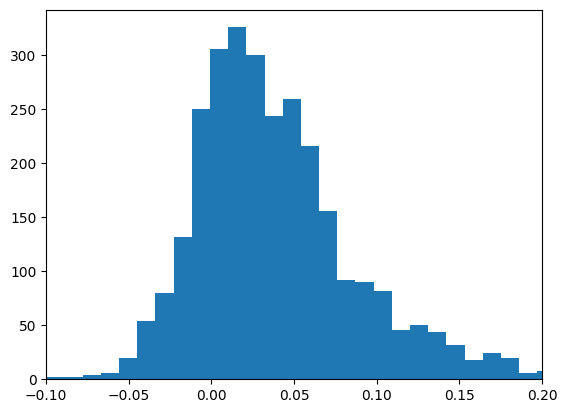

In [5]:
sttc_neo = sd.spike_time_tilings( 20 ) 
plt.hist( sttc_neo.flatten(), bins=100 )
plt.xlim(-.1,.2)


In [6]:

import numpy as np
from human_hip.spike_data import latencies, cross_sttc


def curate_latencies(sd,  latency_ms=30, sttc_cutoff = 0, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ):

    # Get all latencies whose STTC is above some minimum STTC cuttoff
    print(sd.N**2 , "Starting Pairs")
    sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
    pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
    for i in range(sd.N):
        for j in range(i+1,sd.N):
            if sttc_neo[i,j] > sttc_cutoff:
                pairs.append([i,j])
    print( len(pairs), "pairs above sttc cutoff")

    # Get all latencies whose median latency is above some minimum Latency Cuttoff
    pairs_late = [] #lags_late = []
    for pair in pairs:
        pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  #latency= np.median(pair_latencies)
        if len(pair_latencies)>=min_latencies and abs(np.mean(pair_latencies))> latency_cutoff :
            if np.mean(pair_latencies) < 0:
                pair_latencies = latencies( pair[1], pair[0], sd, ms_cutoff_high=latency_ms) 
                if np.mean(pair_latencies)> latency_cutoff and len(pair_latencies)>=min_latencies:
                    t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                    if p_value < pval:
                        pairs_late.append( [ pair[1], pair[0] ] )
            else:
                t_stat, p_value = stats.ttest_1samp( pair_latencies, 0)
                if p_value < pval:
                    pairs_late.append( pair )
    print( len(pairs_late), "pairs above latencency cutoff")

    mean_latencies = []
    for pair in pairs_late:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))
    #good_pairs =   np.array(pairs_final)

    return  pairs_late

In [7]:
latency_ms = 30
good_pairs = curate_latencies(sd, latency_ms=30, sttc_cutoff = 0.01, latency_cutoff=1, sttc_delta=20, pval=.05, min_latencies=25 ) 

# latency_ms = 15
# good_pairs = curate_latencies(sd,  latency_ms=latency_ms, sttc_cutoff = 0.02, latency_cutoff=1, sttc_delta=20, pval=.05 ) 

good_pairs2 = np.array(good_pairs)



3025 Starting Pairs
1059 pairs above sttc cutoff
69 pairs above latencency cutoff
all final pairs positive?: True


In [8]:
#good_pairs
print( len(good_pairs), "good pairs" )

mean_latencies = []
for pair in good_pairs:
    mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
    mean_latencies.append(mean_latency)
print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

69 good pairs
all final pairs positive?: True


In [7]:
# good_pairs = curate_latencies(sd)
# with open( 'chip21769_no_drug_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
##load pickled data
# with open( 'curate_latencies_good_pairs.pkl' , 'rb') as my_file:
#     good_pairs = pickle.load(my_file)
# len(good_pairs)

# Make Plots

all final pairs positive?: True


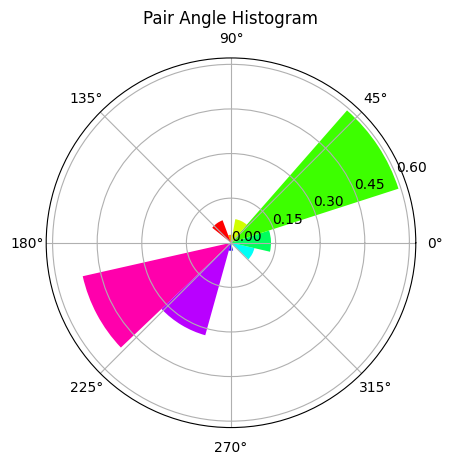

In [8]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=False, late_cutoff_high=latency_ms)

all final pairs positive?: True


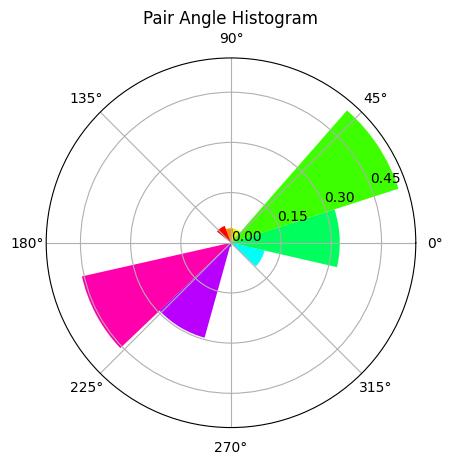

In [9]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True, late_cutoff_high=latency_ms)

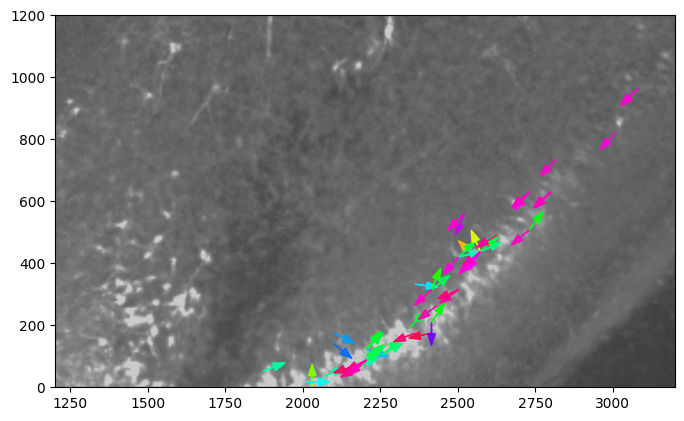

In [10]:
plot_vector_layout( sd, good_pairs2, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200))

In [16]:
from ipywidgets import interact_manual, interact
from scipy import stats

def pairs_hisogram(good_pairs, sd, ms_cutoff_high=latency_ms ):
    @interact
    def plot_pair(pair_i = (0, len(good_pairs)-1) ):
        latencies_pair = latencies( good_pairs[pair_i][0], good_pairs[pair_i][1], sd, ms_cutoff_high=ms_cutoff_high )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)
        print("Pair: ", good_pairs[pair_i][0],good_pairs[pair_i][1] )
        print("Latency Mean:\t", np.mean(latencies_pair ) )

        t_stat, p_value = stats.ttest_1samp( latencies_pair, 0)
        one_sided_p_value = p_value / 2 if t_stat > 0 else 1 - p_value / 2
        print("T-Test 1-Side:\t", one_sided_p_value )  #print("T-Test: ", stats.ttest_1samp(latencies_pair, 0)[1] )
        
pairs_hisogram( good_pairs, sd, ms_cutoff_high=latency_ms)

interactive(children=(IntSlider(value=34, description='pair_i', max=68), Output()), _dom_classes=('widget-inte…

# Curate Arrows

set parameters and import packages thtat are run in function

In [13]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact
from matplotlib.ticker import MaxNLocator
import numpy as np

In [24]:
pairs= good_pairs
image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png"
xlim=(1200,3200)
ylim=(0,1200)
figsize=(8, 8)
sd_cuttoff = 1

run code inside primary function

In [15]:

    # make sure all latencies have positive mean
    pairs = pairs    # ?avoid bug? 
    mean_latencies = []
    for pair in good_pairs:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

all final pairs positive?: True


In [16]:
    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

/tmp/ipykernel_10880/2047253230.py:3: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


In [17]:
    # Latencies count                  
    latency_counts = []
    for pair in pairs:
        latency_counts.append( len(latency_times( pair[0], pair[1], sd, ms_cutoff_high=latency_ms, positive_only=True )) )

In [18]:
    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ [pair[0] for pair in pairs] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ [pair[1] for pair in pairs] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

In [19]:
    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latency_counts[i]
        else:
            pair_dict[key] = [ angles[i] ] * latency_counts[i]


get general idea of sd values

In [22]:
@interact(num=(0,len(pair_dict)))
def angles_hist(num):
    key = list(pair_dict.keys())[num]
    print("SD:", np.std( pair_dict[key] ))
    plt.hist( pair_dict[key] )

interactive(children=(IntSlider(value=16, description='num', max=33), Output()), _dom_classes=('widget-interac…

In [23]:
    # create new dictionary of just mean angles
    pair_angles = {}
    pair_sd = {}
    for key, value in pair_dict.items():
        pair_angles[key] = sum(value) / len(value)
        pair_sd[key] = np.std(value, ddof=1) #/ len(value)


Make two plots to see sd cutoff

/tmp/ipykernel_10880/213045606.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SD cutoff: 0


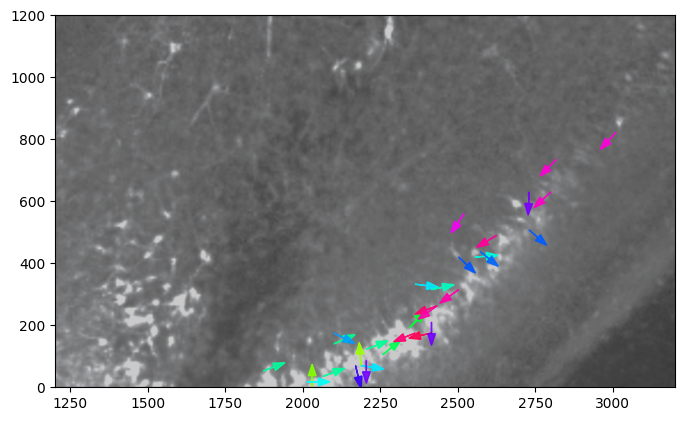

In [27]:
sd_cuttoff = 100

# Plot original scatter
plt.figure(figsize=(8, 8))
ax = plt.axes()
if image_path is not None:
    img = plt.imread(image_path)      # Load in image
    plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
plt.xlim( xlim )
plt.ylim( ylim )    

# Draw Arrows
cmap = cm.get_cmap('hsv')
pair_removed = 0
for pair, angle in pair_angles.items():
    if pair_sd[pair] < sd_cuttoff :
        angle2 = (angle*-1+ np.pi)/np.pi/2
        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)
    else:
        pair_removed = pair_removed + 1
print("Pairs removed by SD cutoff:", pair_removed )

/tmp/ipykernel_10880/440751050.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SD cutoff: 9


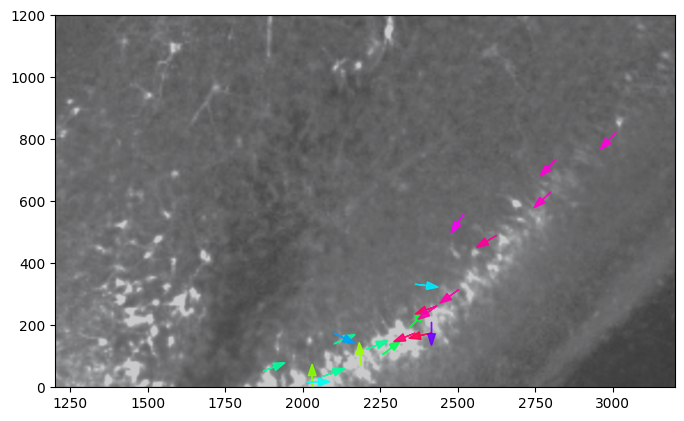

In [26]:
sd_cuttoff = 1

# Plot original scatter
plt.figure(figsize=(8, 8))
ax = plt.axes()
if image_path is not None:
    img = plt.imread(image_path)      # Load in image
    plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
plt.xlim( xlim )
plt.ylim( ylim )    

# Draw Arrows
cmap = cm.get_cmap('hsv')
pair_removed = 0
for pair, angle in pair_angles.items():
    if pair_sd[pair] < sd_cuttoff :
        angle2 = (angle*-1+ np.pi)/np.pi/2
        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)
    else:
        pair_removed = pair_removed + 1
print("Pairs removed by SD cutoff:", pair_removed )

make function

In [30]:
def plot_vector_layout4( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, 
                         sd_cuttoff=100 , latency_ms=30):

    # make sure all latencies have positive mean
    pairs = pairs    # ?avoid bug? 
    mean_latencies = []
    for pair in pairs:
        mean_latency = np.mean( latencies( pair[0], pair[1], sd, ms_cutoff_high=latency_ms)  )
        mean_latencies.append(mean_latency)
    print("all final pairs positive?:", np.all( np.array(mean_latencies)>0 ))

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count                  
    latency_counts = []
    for pair in pairs:
        latency_counts.append( len(latency_times( pair[0], pair[1], sd, ms_cutoff_high=latency_ms, positive_only=True )) )

    # Creat arrows show angle of information flow from a neuron
    starts = neuron_xy[ [pair[0] for pair in pairs] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ [pair[1] for pair in pairs] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latency_counts[i]
        else:
            pair_dict[key] = [ angles[i] ] * latency_counts[i]

    # create new dictionary of just mean angles
    pair_angles = {}
    pair_sd = {}
    for key, value in pair_dict.items():
        pair_angles[key] = sum(value) / len(value)
        pair_sd[key] = np.std(value, ddof=1) #/ len(value)

    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    pair_removed = 0
    for pair, angle in pair_angles.items():
        if pair_sd[pair] < sd_cuttoff :
            angle2 = (angle*-1+ np.pi)/np.pi/2
            start = neuron_xy[ pair ]  
            arrow = FancyArrow( 
                    start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                    linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
            plt.gca().add_patch(arrow)
        else:
            pair_removed = pair_removed + 1
    print("Pairs removed by SD cutoff:", pair_removed )

all final pairs positive?: True


/tmp/ipykernel_10880/3330675879.py:14: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_10880/3330675879.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


Pairs removed by SD cutoff: 9


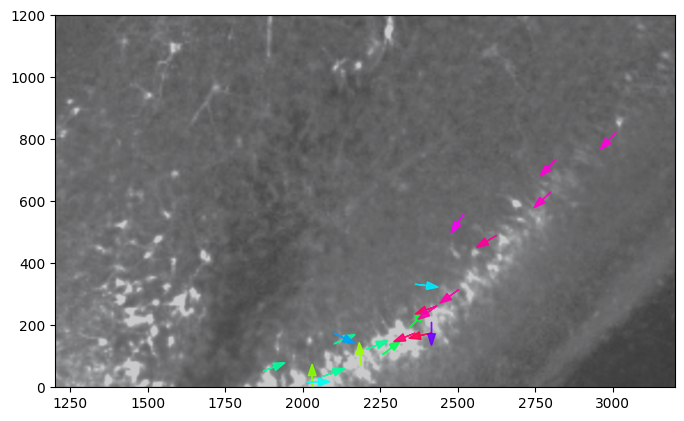

In [31]:
plot_vector_layout4( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png", figsize=(8, 8),
                     xlim=(1200,3200), ylim=(0,1200), sd_cuttoff=1 , latency_ms=30)